[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/UNSW-COMP9418/Week07/blob/main/COMP9418_W07_Markov_Netwoks_and_Conditional_Random_Fields.ipynb)

# Markov Networks and Conditional Random Fields

**COMP9418 W07 Tutorial**

- Instructor: Gustavo Batista
- School of Computer Science and Engineering, UNSW Sydney 
- Notebook designed by Gustavo Batista and Jeremy Gillen
- Last Update 6th September 2022

In this week's tutorial, we will explore the class of undirected graphs known as *Markov networks* or *Markov Random Fields*. These networks are used to model symmetrical dependencies between random variables. These models are particularly popular in areas such as image and language processing.

## Technical prerequisites

You will need certain packages installed to run this notebook.

If you are using ``conda``'s default
[full installation](https://conda.io/docs/install/full.html),
these requirements should all be satisfied already.

If you are using ``virtualenv`` or other native package management,
you may need to run these commands:

```python
pip3 install numpy matplotlib
```

Once you have done all that, you can import some useful modules for later use.

In [1]:
# Necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Libraries for creating and assessing machine learning classifiers
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# combinatorics
from itertools import product, combinations
# clear display
from IPython import display
# access to math.log2
import math
# random number generator
import random as rnd
import string

In [2]:
from DiscreteFactors import Factor
from Graph import Graph
from BayesNet import BayesNet

# Image smoothing
Let's start illustrating how Markov networks work with image smoothing. Remember that image smoothing is the process of removing random noise from an image. For instance, pictures taken in low illumination conditions frequently appear *pixelated*.

We start loading one image we will use to test our Markov network.

Image size:
256 x 256


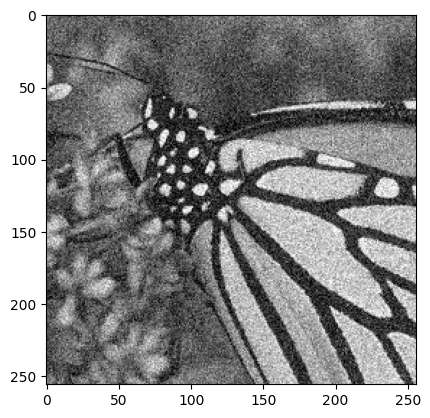

In [3]:
# Download image file and store in img directory
#!mkdir img
#!curl https://raw.githubusercontent.com/UNSW-COMP9418/Week07/main/img/05_25_noisy.png --output img/05_25_noisy.png

img_noisy=mpimg.imread('img/05_25_noisy.png')
plt.imshow(img_noisy, cmap='gray')
(size_x, size_y) = img_noisy.shape
print("Image size:")
print(size_x, "x", size_y)

We can see this is a small 256 x 256 grayscale image. The colour values are numbers between 0 and 255. Even for a small image like this, we need to be careful with our implementation. Otherwise, we can end up with a code that is too slow or use too much memory. Our Markov networks will use the following graph structure.

![](./img/image_graph.png)

Where $Y_{i,j}$ is a pixel in the input (noisy) image and $X_{i,j}$ is a pixel in the output (filtered) image. To represent both images, we will use 2-dimensional matrices (256 x 256) instead of factors.

Also, our model will have two forms of pairwise potentials:
1. $\psi(X_{i,j}, X_{i',j'})$ represents the correlations between neighbouring pixels.
2. $\psi(X_{i,j}, Y_{i,j})$ describes the correlations between pixels in the same position in the noisy and filtered images.

The final component of our model is the energy function. In general, the energy function has the following format:

$$E(\textbf{X})=\sum_{c\in Cliques(G)}\psi_c(\textbf{X}_c)$$

Let's instantiate this energy function to our problem. Our cliques are pairwise connections between pixels. We will assume the neighboring pixes are in the positions $(i-1, j), (i+1, j), (i, j-1), (i, j+1)$. Therefore, we have:

$$E(\textbf{X})=\sum_{i,j}\psi(X_{i,j}, Y_{i,j})+\psi(X_{i,j}, X_{i+1,j})+\psi(X_{i,j}, X_{i,j+1})$$


## Stochastic Search

We will now implement the image smoothing using Markov networks. We will develop a stochastic search algorithm, as described in the lecture.

This algorithm will choose one pixel and change its value. If such a change decreases the total image energy, we will accept the change. Otherwise, the change will be ignored, and we move to another pixel. Besides, the algorithm will accept changes that increase the energy with a small probability of $p$ in an attempt to avoid local minima.

Remember that our objective is to compute an MPE query (we are interested in the filtered image with the highest probability/smallest energy). Therefore, the stochastic search algorithm will move towards a (local) minima through a series of changes in the pixel values.

To improve the code efficiency, we note that a change in a single pixel can only affect the pixel neighbourhood. Therefore, we will only compute the following function to assess the difference in the energy function:

$$\Delta E(\textbf{X})=\psi(X_{i,j}, Y_{i,j})+\psi(X_{i,j}, X_{i+1,j})+\psi(X_{i,j}, X_{i,j+1})+\psi(X_{i,j}, X_{i-1,j})+\psi(X_{i,j}, X_{i,j-1})$$

Let's start defining some helper functions.

In [4]:
### This helper function converts a number between 0 and x*y into an (x,y) coordinate
def int_to_coord(pos, size_y):
    """
    argument 
    `pos`, a position expressed as an integer number between 0 and image's size_x * size_y
    `size_y`, number of columns of the image matrix
    
    Returns pos converted into a (x, y) coordinate
    """
    return int(pos / size_y), pos % size_y

# This helper function returns a list with the neighbours of a (x, y) pixel respecting the image limits
def neighbours(x, y, size_x, size_y):
    """
    argument 
    `x, y`, pixel coordinate
    `size_x, size_y`, image size
    
    Returns a list with valid (x, y) neighbours
    """
    
    neighbours = list()
    if x > 0:
        neighbours.append((x-1, y))
    if x < size_x - 1:
        neighbours.append((x+1, y))
    if y > 0:
        neighbours.append((x, y-1))
    if y < size_y - 1:
        neighbours.append((x, y+1))
    return neighbours

# This helper function defines energy between two data points
def energy_point(x, y):
    """
    argument 
    `x, y`, pixel color [0,255] range

    Returns the absolute difference between x and y. Other measures of dissimilarity may also work such as (x - y)**2
    """    
    return abs(x - y)
    
# This helper function plots the results every 10 iterations so we can see the convergence
def plot_results(it, image_x, image_y, energies, max_iter):
    """
    argument 
    `it`, current iteraction
    `image_x`, filtered image
    `image_y`, observed image
    `energies`, list of energy values computed for each iteration
    `max_iter`, maximum number of iterations
    """    
    
    (size_x, size_y) = image_y.shape
    energy = sum([energy_point(image_x[x][y], image_y[x][y]) for x in range(size_x) for y in range(size_y)])
    energy += sum([energy_point(image_x[x][y], image_x[x+1][y]) for x in range(size_x-1) for y in range(size_y)])
    energy += sum([energy_point(image_x[x][y], image_x[x][y+1]) for x in range(size_x) for y in range(size_y-1)])
    energies.append(energy)               
    display.clear_output(wait=True)
    print("Iteration:")
    print(it)
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    axes = plt.gca()
    axes.set_xlim([0, max_iter])
    axes.set_ylim([min(max(energies)/2,min(energies)), max(energies)])
    plt.plot(energies, 'ro')
    plt.subplot(2, 2, 3)
    plt.imshow(image_y, cmap='gray') 
    plt.subplot(2, 2, 4)    
    plt.imshow(image_x, cmap='gray') 
    plt.show()

## Exercise

Now, it is your turn. Let's implement a stochastic search. We have created a stub for you. You only need to fill in a few gaps. (This function will take a while, give it >20 seconds to produce output).

In [ ]:
def stochastic_search(image_y, max_iter=101, eps=.001, step_stdev=.05):
    """
    argument 
    `image_y`, observed image
    `max_iter`, maximum number of iteractions
    `eps`, probability of accepting a higher energy change
    `step_stdev`, standard deviation. Changes are randon numbers from a Gaussian distribuion N(0, step_stdev)
    """
    
    # List of energy values for each iteration. Initialise with empty list
    energies = []
    # Image size expressed as number of rows and columns
    (size_x, size_y) = image_y.shape
    # Image size expressed as number of pixels
    size = size_x * size_y
    # Let's use image_y as starting point for image_x. It will be faster than if we start with a random assignment
    image_x = image_y.copy()

    for it in range(max_iter):
        # order has the indexes of all pixels in the image
        order = list(range(size))
        # Let's shuffle these indexes so each pass will use a different order
        rnd.shuffle(order)
        for o in order:
            # Use the int_to_coord helper function to convert o into an (x,y) coordinate
            (x, y) = int_to_coord(o, size_y)                                                                     # 1 line
            # Use energy_point to initialise energy_prev with the energy between image_x and image_y in the same pixel position (x, y)
            energy_prev = energy_point(image_x[x][y], image_y[x][y])                                                              # 1 line
            # step defines the change in image_x pixel. We will use a random value from a normal distribution with mean zero and a small standard deviation
            step = rnd.gauss(0, step_stdev)
            # Use energy_point to initialise energy_post with the energy between image_x +step and image_y in the same pixel position (x, y)
            energy_post = energy_point(image_x[x][y] + step, image_y[x][y])                                                                 # 1 line
            # Use neighbours to find all valid neighbours of the current pixel
            for (i, j) in neighbours(x, y, size_x, size_y):
                # Use energy_point to update energy_prev for each neighbour pixel
                energy_prev += ... # TODO                                                             # 1 line
                # Use energy_point to update energy_post for each neighbour pixel
                energy_post += ... # TODO                                                             # 1 line
            # Update image_x if the change led to an decrease of energy    
            if energy_post < energy_prev or rnd.random() < eps:
                image_x[x][y] += step
        # Call plot_results to show the progress so far
        plot_results(it, image_x, image_y, energies, max_iter)

##################
# Test code

stochastic_search(img_noisy, max_iter=35)

# Conditional Random Fields (CRFs)

Conditional Random Fields are *discriminative* graphical models. These models are a very popular way to integrate the output of multiple independent classifiers into a more complex structured prediction.

A simple example is the classification of sequences. As the next figure illustrates:

![](./img/chain_CRF.png)

This is a *linear chain CRF* in which we want to predict an entire word given predictions for individual letters.

In this part of the tutorial, we will implement this application of word prediction using Machine Learning classifiers trained to recognise individual letters.

Let's start by reading the dataset. It is a large dataset of handwritten letters made available in a [Kaggle competition](https://www.kaggle.com/ponrajsubramaniian/az-handwritten-digits). 

This dataset may take a while to load. If your computer has a few GB of memory free, use the larger dataset 'data/A_Z_Handwritten_Data.csv'. If not, use the smaller dataset 'data/A_Z_Handwritten_Data_Small.csv', which is used by default below.

In [ ]:
!mkdir data
!curl https://raw.githubusercontent.com/UNSW-COMP9418/Week07/main/data/A_Z_Handwritten_Data_Small.csv --output data/A_Z_Handwritten_Data_Small.csv

dataset = np.loadtxt('data/A_Z_Handwritten_Data_Small.csv', delimiter=',')

This is a reasonably large set of handwritten characters, let's see how many examples and attributes we have.

In [ ]:
(num_examples, num_attributes) = dataset.shape
print("Number of examples", num_examples)
print("Number of attributes", num_attributes)

The first attribute is the class label, encoded as 0 = 'a', 1 = 'b', and so on. Let's remove this column from the data, so there will be no risk of incorrectly providing this information to the classifier as a regular feature.

In [ ]:
X = dataset[:,1:785]
Y = dataset[:,0]

Also, the following helper function will be handy when we need to convert the class numbers 0-25 into letters a-z.

In [ ]:
def num_to_letter(n):
    return string.ascii_lowercase[int(n)]

################
# Test code

for i in range(26):
    print(num_to_letter(i), end='')

Let's now split the dataset into training and test sets. We use a 50%-50% split since we have plenty of data.

In [ ]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.50)

The data is provided as a CSV file with 784 attributes. Now, we convert the data to 28 x 28-pixel images so that we can visualise part of the dataset. Notice that we created new variables `X_train_img` and `X_test_img` to preserve the original data for training and testing the models.

In [ ]:
# Reshape images, from 1 x 784 to 28 x 28
X_train_img = X_train.reshape(X_train.shape[0], 28, 28).astype('float32')
X_test_img = X_test.reshape(X_test.shape[0], 28, 28).astype('float32')

# The pixel values are numbers in the range 0..255. We need to convert into 0..1 range
X_train_img = X_train_img / 255
X_test_img = X_test_img / 255

The next cell plots some random images so that we can have a better feeling of the appearance of the handwritten letters.

In [ ]:
plt.figure(figsize = (12,10))
row, colums = 4, 4
for i in range(16):  
    plt.subplot(colums, row, i+1)
    plt.imshow(X_train_img[i],interpolation='nearest', cmap='Greys')
plt.show()

## Machine Learning classifier for recognition of individual letters

We have loaded and prepared our data. It is time to build some models. We can create any model we want, and you are invited to test different models later on.

In this part of the tutorial, we will use Random Forests (RF) as classifiers for several reasons:

1. They are simple to train. Although RFs have several hyperparameters, they often provide very good results with default parameter values.
2. They are naturally multiclass. Since we have 26 classes, it is simpler to deal with a classifier that can handle all of them, instead of converting the data into multiple binary-class datasets.
3. They frequently provide competitive classification accuracy compared to other state-of-the-art Machine Learning classifiers.

A downside is that Random Forests are ensemble classifiers that typically use a few hundred trees. Therefore, they tend to be slow for training and classification. 

The next cell will build a model. Since we have a large dataset, we will limit the number of trees to 100. You can play with this and other settings later on. The next cell will take a while to run.

In [ ]:
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))
print(accuracy_score(Y_test, Y_pred))

You can inspect the performance results to check the classes that are frequently misclassified. We can also see that the overall performance is quite good, typically above 97% accuracy. (Around 90% for small dataset)

## Making words

Unfortunately, our dataset does not have words, only handwritten characters. Therefore, we will have to develop a series of functions to produce words from characters. We start with a helper function that creates a Python dictionary. The dictionary keys are letters (a-z), and the items are lists with the indexes of the handwritten characters in the *test* set.

In [ ]:
# Helper function, creates a python dictionary maping lowercase letters to indexes of examples in the test set
def letter_idxs():
    letters = {}
    for i in range(26):
        letters[num_to_letter(i)] = []
    for i in range(len(Y_test)):
        letters[num_to_letter(Y_test[i])].append(i)
    return letters

#################
# Test code

letters_idx_dict = letter_idxs()
print("Some examples of letters 'a' in the test set")
plt.figure(figsize = (12,10))
row, colums = 4, 4
for i in range(16):  
    plt.subplot(colums, row, i+1)
    plt.imshow(X_test_img[letters_idx_dict['a'][i]],interpolation='nearest', cmap='Greys')
plt.show()

We use the letters dictionary to create words composed by the handwritten characters in the test set. We will use these words to test our classifiers. The next helper function produces a sequence of character images given a string. We randomly pick a letter from the test set.

In [ ]:
# This helper function converts an string into a sequence of indexes of test set examples. The indexes are randomly chosen by respect the letters in the string
def make_word(word, letters, X_test):
    '''
    Returns a list of np arrays (images), one corresponding to each letter in the word
    '''
    letter_indicies = [rnd.choice(letters[char]) for char in word]
    return [X_test[idx] for idx in letter_indicies]

Now, we can test these function by printing a word such as "bayes". If you want to try different words, remember to use lowercase letters.

In [ ]:
# This helper function prints a sequence of handwritten letters specified by word
def print_word(word_imgs):
    f, axarr = plt.subplots(1,len(word_imgs))
    for i, letter_image in enumerate(word_imgs):
        letter_image = np.reshape(letter_image, (28, 28))
        axarr[i].imshow(letter_image,cmap='Greys')
        axarr[i].axis('off')
    plt.show()
    
##################
# Test code

rnd.seed(1)
letters_idx_dict = letter_idxs()
word_imgs = make_word("bayes", letters_idx_dict, X_test_img)
print_word(word_imgs)

Finally, we can classify a word using our Random Forest classifier. 

In [ ]:
# This helper function classifies a sequence of handwritten letters using the RF classifier

def classify_random_forest(word_imgs):
    pred = classifier.predict([letter_image for letter_image in word_imgs])
    pred_word = ''.join([num_to_letter(i) for i in pred])
    return pred_word

##################
# Test code

rnd.seed(1)
word_imgs = make_word("bayes", letters_idx_dict, X_test)
print_word(word_imgs)
print("Classification (Random Forest):", classify_random_forest(word_imgs))

## Log Factors

Before we move on to making a Conditional Random Field classifier, lets make a class to represent logarithmic factors. These work the same as normal factors, except when we join factors we have to add the values instead of multiplying them.

In [ ]:
class LogFactor(Factor):
    def join(self, other):
        '''
        Usage: `new = f.join(g)` where f and g are Factors
        This function multiplies two factors.
        '''
        # confirm that any shared variables have the same outcomeSpace
        for var in set(other.domain).intersection(set(self.domain)):
            if self.outcomeSpace[var] != other.outcomeSpace[var]:
                raise IndexError('Incompatible outcomeSpaces. Make sure you set the same evidence on all factors')
        # extend current domain with any new variables required
        new_dom = list(self.domain) + list(set(other.domain) - set(self.domain)) 
        # to prepare for multiplying arrays, we need to make sure both arrays have the correct number of axes
        self_t = self.table
        other_t = other.table
        for _ in set(other.domain) - set(self.domain):
            self_t = self_t[..., np.newaxis]     
        for _ in set(self.domain) - set(other.domain):
            other_t = other_t[..., np.newaxis]
        # And we need the new axes to be transposed to the correct location
        old_order = list(other.domain) + list(set(self.domain) - set(other.domain)) 
        new_order = []
        for v in new_dom:
            new_order.append(old_order.index(v))
        other_t = np.transpose(other_t, new_order)
        # Now that the arrays are all set up, we can rely on numpy broadcasting to work out which numbers need to be added.
        new_table = self_t + other_t
        # The final step is to create the new outcomeSpace
        new_outcomeSpace = self.outcomeSpace.copy()
        new_outcomeSpace.update(other.outcomeSpace)
        return self.__class__(tuple(new_dom), new_outcomeSpace, table=new_table)

    def marginalize(self, var):
        raise NotImplementedError("We don't usually marginalize log factors")
    def normalize(self):
        raise NotImplementedError("We don't usually normalize log factors")

## Conditional Random Field (CRF)

Let's start coding our CRF model. This model is a Markov network with two kinds of potentials:

1. $\phi_i(Y_i,x_i)$ is the score provided by the classifier for each character image $x_i$. Notice that $Y_i$ is a vector of scores, one for each class (letter).
2. $\phi(Y_i, Y_{i+1})$ is a measure of co-occurrence of consecutive letters. We will use the probability of occurrence of two successive letters in a dictionary. Therefore, we will need to estimate these quantities from the data.

Our first task is to compute $P(y_i, y_{i+1})$. We need a large dataset of words. We can find several of them online. We will use one with [466k English words](https://github.com/dwyl/english-words).

Let's start loading it into memory. It has one word per line.

In [ ]:
!curl https://raw.githubusercontent.com/UNSW-COMP9418/Week07/main/data/words_alpha.txt --output data/words_alpha.txt

text_file = open('data/words_alpha.txt', 'r')
word_dataset = text_file.readlines()

Before computing the factors for our CRF, it is interesting to evaluate the accuracy of the RF model to recognise entire words correctly. Let's start by splitting the word dataset into training and test sets.

In [ ]:
(W_train, W_test) = train_test_split(word_dataset, test_size=0.01)

The next function will compute the accuracy of the test set. We reserve the training set to compute $\phi(Y_i, Y_{i+1})$ later on.

We define a "word accuracy" as the percentage of words that were correctly recognised in the test set. To be correctly identified, the classifier must correctly recognise every letter. Therefore, we can expect a much lower accuracy for words that the one we got for individual letters.

The next cell may take a while to run.

In [ ]:
def word_accuracy(words, letters_idx_dict):
    acc = 0
    for word in words:
        word = word.rstrip()
        w = make_word(word, letters_idx_dict, X_test)
        pred_word = classify_random_forest(w)
        if pred_word == word:
            acc+=1
    return acc/len(words)

###################
# Test code

print("Word accuracy (Random Forest):", word_accuracy(W_test, letters_idx_dict))

Indeed, we got an accuracy above 72% for words. It is considerably lower than the one we got for letters (around 97%). (For small dataset, we get ~42% for word accuracy).




## Exercise

It is time to compute the probability of the occurrence of consecutive letters. We will use the training partition of the word list to compute these probabilities. Let's use Laplace smoothing to avoid zero probabilities.

After computing each probability, we will store it in a "transition" factor $\phi(Y_i, Y_{i+1})$. We will call this factor a "transition" factor since it quantifies the strength of transitioning between consecutive letters. This factor is quite large since it stores $26^2$ entries expressing the transition probabilities between all possible pairs of letters. 

Let's implement the function `create_transition_factor`. We will use log-probabilities to avoid underflow issues later. We have implemented part of the code for you.

In [ ]:
outcomeSpace = {
    'L':('a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'),
    'L_next':('a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'),
}

def create_transition_factor(W_train, outcomeSpace, gamma=0.1):
    """
    argument 
    `W_train`, a training dataset of words,
    `outcomeSpace`, a dictionary with variables and their scope
    `gamma`, a parameters to adjust the influence of the transition_factors
    
    Returns a transition factor that expresses hte correlation between two consecutive letters. The values are log-probabilities of occurrence of consecutive letters
    """
    # Dictionary to map two-letter strings into occurrence counts
    count_letters = {}
    # Lets initialise the disctionary with zero counts
    for two_letters in product(string.ascii_lowercase, string.ascii_lowercase):
        count_letters[two_letters] = ... # TODO
    # Now, we scan all words in the training set
    for word in W_train:
        # Remove the \n character
        word = word.rstrip()
        # Finally, we scan every letter in a word and increment the occurrences
        for i in range(len(word)-1):
            count_letters[(word[i],word[i+1])] += ... # TODO
    # Let's compute the total number of occurrence
    total_letters = ... # TODO

    tFactor = LogFactor(('L', 'L_next'), outcomeSpace)
    for key, value in count_letters.items():
        # Compute the empirical probabilities from the counts and apply smoothing with k = 1
        prob = (value + 1) / (total_letters + len(string.ascii_lowercase) ** 2)
        # Populate the factor with log-probabilities multiplied by the parameter gamma. Use math.log2
        tFactor[key] = ... # TODO

    return tFactor

###########
# Test code

gamma = 0.1
tFactor = create_transition_factor(W_train, outcomeSpace, gamma=gamma)

print("gamma*logP(QU) = ", tFactor['q', 'u'])
print("gamma*logP(QV) = ", tFactor['q', 'v'])

print("P(QU) = ", 2**(tFactor['q', 'u']/gamma))
print("P(QV) = ", 2**(tFactor['q', 'v']/gamma))

If your code is correct, you should see an output similar to this one (the exact values will differ because of the random partitions of the data)
```
gamma*logP(QU) =  -0.9081278288352004
gamma*logP(QV) =  -1.9976096051659948
P(QU)= 0.0018416920553839273
P(QV)= 9.696518368114745e-07
```


Similarly, we define a function to create the factors $\phi_i(Y_i, x_i)$. We call these "classification factors". There will be one of those factors for each input character. 

## Exercise 

Let's implement the `classification_factors` function. This function receives a list of indexes with the position of the letters in the test set. For each letter, we will create one factor. This factor has the log-probabilities assigned by a classifier to each class. 

We have already started the code for you.

In [ ]:
def classificationFactors(word_imgs):
    """
    argument 
    `word_idx`, a list with test set indexes for each letter that form a word
    
    Returns a list of classification factors. Each factor has the probabilities assigned by a classifier to each letter and class
    """    
    np.seterr(divide = 'ignore') 
    # use classifier.predict_log_proba to return the log-probabilities for each letter in word_idx
    log_prob = ... # TODO 1 line with list comprehension
    np.seterr(divide = 'warn') 
    # This variable has the list of factors we will return. We start with an empty list
    factors = []    
    for i in range(len(word_imgs)):
        # Create an empty factor
        f = LogFactor(('L',), outcomeSpace)
        for letter in outcomeSpace['L_next']:
            # Populate the factor with the log-probabilities in log_prob
            f[letter] = ... # TODO 1 line
        factors.append(f)
    return factors

The next three functions implement the Viterbi algorithm for CRFs. They are almost trivial adaptations of the same functions we implemented for Hidden Markov Models. For instance, instead of expecting transition and emission probabilities, these functions expect as input transition and classification factors. 

In [ ]:
class ConditionalRandomField():
    def __init__(self, first_state, tFactor, variable_remap):
        self.state = first_state
        self.transition = tFactor

        self.remap = variable_remap

        self.history = []
        self.prev_history = []

    def viterbiStep(self, observationFactor):

        # confirm that state and emission each have 1 variable 
        assert len(self.state.domain) == 1
        assert len(self.transition.domain) == 2

        # get state and evidence var names (to be marginalized and maximised out later)
        state_var_name = self.state.domain[0]

        # join with transition factor
        f = self.state*self.transition

        # maximize out old state vars, leaving only new state vars
        f, prev = f.maximize(state_var_name, return_prev=True)
        self.prev_history.append(prev)

        # remap variable to it's original name
        f.domain = tuple(self.remap[var] for var in f.domain)

        # join observation factor with state factor
        f = f*observationFactor

        self.state = f 

        self.history.append(self.state)

        return self.state

    def viterbiBatch(self, observationFactorList):
        '''
        emissionEviList: A list of dictionaries, each dictionary containing the evidence for that timestep. 
                         Use `None` if no evidence for that timestep
        '''
        for observationFactor in observationFactorList:
            # select evidence for this timestep
            self.viterbiStep(observationFactor)
        return self.history

    def traceBack(self):
        # get most likely outcome of final state
        index = np.argmax(self.history[-1].table)
        
        # Go through "prev_history" in reverse
        indexList = []
        for prev in reversed(self.prev_history):
            indexList.append(index)
            index = prev[index]
        indexList = reversed(indexList)

        # translate the indicies into the outcomes they represent
        mleList = []
        stateVar = self.state.domain[0]
        for idx in indexList:
            mleList.append(self.state.outcomeSpace[stateVar][idx]) 
        return mleList

## Exercise

Implement the `classify_word_crf` function that uses the Viterbi algorithm to classify a word represented y a list of indexes.

In [ ]:
def classify_word_crf(word_imgs, tFactor):
    # Compute the observation factors for word_imgs (individual letter classification)
    observationFactorList = classificationFactors(word_imgs)
    
    # Initialize a conditionalRandomField, using the first observation factor as the start factor
    ... # TODO
    # Use Viterbi algorithm to compute the time line
    ... # TODO
    # Obtain the MPE assigment by tracing back over the timeline
    ... # TODO
    return ... # TODO return the word


##################
# Test code

rnd.seed(1)
letters_idx_dict = letter_idxs()
word_imgs = make_word("bayes", letters_idx_dict, X_test)
tFactor = create_transition_factor(W_train, outcomeSpace)
print_word(word_imgs)
print(classify_word_crf(word_imgs, tFactor))

We are finally in a position to use the CRF to classify words. The approach is to use the Viterbi algorithm and return the MPE assignment. The next function will perform this task.

As the last step, we can compare the classification accuracy of Random Forest and Conditional Random Field. The next function will perform this task.

## Exercise

Implement `compare_acc` to compute the accuracy of RF and CRM in the test set partition of the word dataset.

The next cell will take a while to run.

In [ ]:
def compare_acc(W_train, W_test, outcomeSpace):
    """
    argument 
    `W_train`, the training set partition of the word dataset.
    `W_test`, the test set partition of the word dataset.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a word predicted by the CRF model
    """    
    acc_rf = 0
    acc_crf = 0
    # Compute the letter indexes by calling the appropriate function
    letters_dict = ... # TODO
    # Compute the transition factor 
    tFactor = create_transition_factor(W_train, outcomeSpace)
    for word in W_test:
        word = word.rstrip()
        # Transform the word string in a list of letter indexes
        word_imgs = ... # TODO
        # Classify word_idx using the CRF model
        word_crf = ... # TODO
        # Classify word_idx using the RF model
        word_rf = ... # TODO
        if word_rf == word:
            acc_rf += 1
        if word_crf == word:
            acc_crf += 1
    return acc_rf/len(W_test), acc_crf/len(W_test)

##################
# Test code

acc_rf, acc_crf = compare_acc(W_train, W_test, outcomeSpace)
print("Accuracy RF:", acc_rf)
print("Accuracy CRF:", acc_crf)

If your implementation is correct, you should see a significant improvement in classification accuracy. The CRF model should perform around 80% accuracy, while the RF has about 73%. (On the small dataset, accuracy should be about 42% and 60%). 

That is all for today. See you next week!